# Task
**Using ESOL dataset develop machine learning models (linear regression, decision tree and random forest) to  predict measured log solubility, using the following five features listed in the dataset:  Molecular Weight, Number of H-Bond Donors, Number of Rings, Number of Rotatable Bonds, Polar Surface Area.**

* *Randomly split 80% of the data as training data, and then randomly split the  rest to validation and test set. The overall ratio of train:valid:test will be approximately 8:1:1.*
* *For initial data discovery and visualization, carry out for training and validation sets separately, and compare their results. Besides those five features, also visualize and calculate correlation between ESOL predicted log solubility and measured log solubility, as well as their RMSE.*

### step 1: Look at the Big Picture:
This model's task is to predict **measured log solubility** using the following 5 features listed in the dataset: Molecular Weight, Number of H-Bond Donors, Number of Rings, Number of Rotatable Bonds, Polar Surface Area.

This is a supervised learning task since the model will be trained with labelled data. The task is a univariate multiple regression problem, since the model will use multiple features to predict one value. We will use RMSE as the performance measure and also take a look at the correlation coefficient.

### step 2: Get the Data

In [43]:
# import required modules
import numpy as np
import pandas as pd

In [44]:
# import ESOL dataset (saved locally)
esol_data = pd.read_csv("delaney_processed.csv")

# double-check that the correct dataset is imported
esol_data.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [45]:
# drop the columns which will not be used in the model
relevant_esol_data = esol_data.drop(columns=[
    'Compound ID',
    'ESOL predicted log solubility in mols per litre', 
    'Minimum Degree', 
    'smiles'])

# check that it is modified correctly
relevant_esol_data.head()

,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
0,457.432,7,3,7,202.32,-0.77
1,201.225,1,2,2,42.24,-3.30
2,152.237,0,0,4,17.07,-2.06
3,278.354,0,5,0,0.00,-7.87
4,84.143,0,1,0,0.00,-1.33


In [46]:
relevant_esol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Molecular Weight                           1128 non-null   float64
 1   Number of H-Bond Donors                    1128 non-null   int64  
 2   Number of Rings                            1128 non-null   int64  
 3   Number of Rotatable Bonds                  1128 non-null   int64  
 4   Polar Surface Area                         1128 non-null   float64
 5   measured log solubility in mols per litre  1128 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 53.0 KB


This data looks good. There do not seem to be any missing values. All of the datatypes are numerical, however, I would like to take a closer look the integer attributes to see if they might be better suited for categories.

In [47]:
relevant_esol_data['Number of H-Bond Donors'].value_counts()

0     635
1     307
2     137
3      22
4      11
6       6
5       6
8       2
7       1
11      1
Name: Number of H-Bond Donors, dtype: int64

In [48]:
relevant_esol_data['Number of Rings'].value_counts()

1    386
0    317
2    221
3    116
4     63
5     16
6      4
7      3
8      2
Name: Number of Rings, dtype: int64

In [49]:
relevant_esol_data['Number of Rotatable Bonds'].value_counts()

0     361
1     232
2     174
3     102
4      86
5      57
6      40
8      24
7      22
9       9
10      6
12      4
14      3
16      2
13      2
11      1
15      1
23      1
17      1
Name: Number of Rotatable Bonds, dtype: int64

In [50]:
relevant_esol_data.describe()

,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


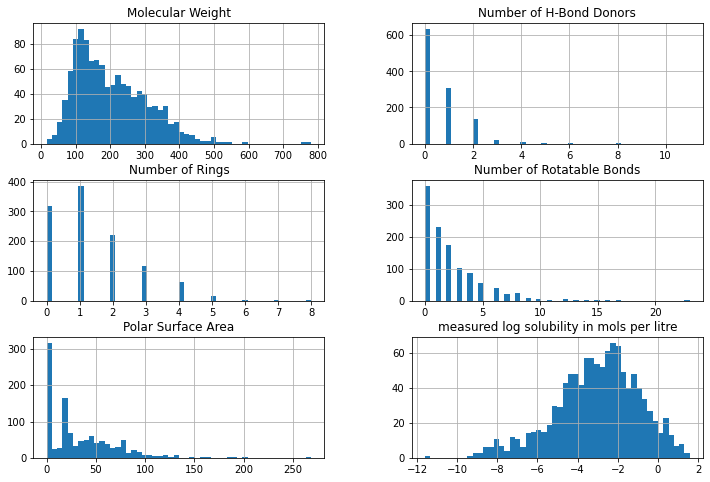

In [51]:
import matplotlib.pyplot as plt

relevant_esol_data.hist(bins=50, figsize=(12, 8))
plt.show()

Many of the attributes have skewed distributions. They might need to be transformed later. 

**Split the Data into Sets**

In [52]:
# set the random state
np.random.seed(23)

In [53]:
from sklearn.model_selection import train_test_split

# take the data and randomly split it into two groups of preset sizes
train_set, valid_and_test_set = train_test_split(relevant_esol_data, test_size=0.2)

# split the smaller group into validation and test sets
valid_set, test_set = train_test_split(valid_and_test_set, test_size=0.5)

# create an array to hold the sizes of the 3 sets
# not necessary, but makes it *slightly* easier to print the data
set_size = [len(train_set), len(valid_set), len(test_set)]

print("training set size:", len(train_set))
print("validation set size:", len(valid_set))
print("test set size:", len(test_set), "\n")

# print the ratios of the sets
print("train/valid/test: {:0.2f}/{:0.2f}/{:0.2f}".format(
    len(train_set)/len(test_set), 
    len(valid_set)/len(test_set),  
    len(test_set)/len(test_set)))

training set size: 902
validation set size: 113
test set size: 113 

train/valid/test: 7.98/1.00/1.00


### step 3: Explore and Visualize Data

**Take a look at the performance of previous predictions — ESOL Predicted Log Solubility vs Measured Log Solubility**

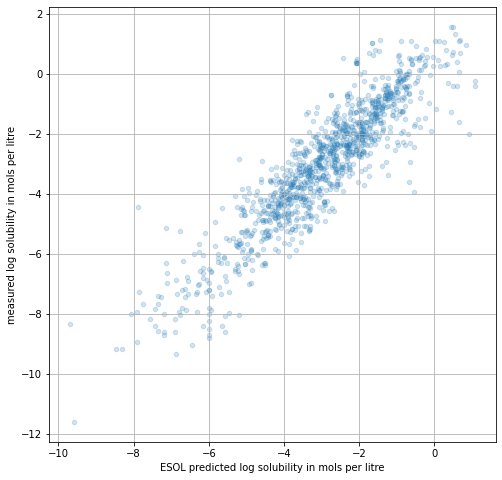

In [54]:
# plot ESOL_predicted data vs measured data
predicted = 'ESOL predicted log solubility in mols per litre'
measured = 'measured log solubility in mols per litre'

esol_data.plot(kind='scatter', x=predicted, y=measured, alpha=0.2, grid=True, figsize=(8,8))
plt.show()

In [55]:
# calculate the correlation coefficient
predicted_data = esol_data[predicted]
measured_data = esol_data[measured]

predicted_data.corr(measured_data)

0.9072640921344202

In [56]:
# calculate RMSE
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(esol_data[measured], esol_data[predicted], squared=False)
rmse

0.9101322725549837

There is a strong positive correlation between the ESOL predictions and the measured log solubility values. This is evident in the scatter plot and the high correlation coefficient of 0.907. In addition, the shape fo the scatter plot roughly resembles the line $y=x$, indicating a roughly 1 to 1 mapping between the predicted and measured values. In addition, the RMSE indicates a typical prediction error of 0.91 which is small relative to the scale of the data. The ESOL predicted values are very accurate, and assuming that the ESOL model was not overfitted, their model is very good.

**Training Set**

In [57]:
# create a copy of the training set to experiment with
train_copy = train_set.copy()

In [58]:
# look for correlations
corr_matrix = train_copy.corr()

corr_matrix['measured log solubility in mols per litre'].sort_values(ascending=False)

measured log solubility in mols per litre    1.000000
Number of H-Bond Donors                      0.183333
Polar Surface Area                           0.111247
Number of Rotatable Bonds                   -0.245098
Number of Rings                             -0.520763
Molecular Weight                            -0.647660
Name: measured log solubility in mols per litre, dtype: float64

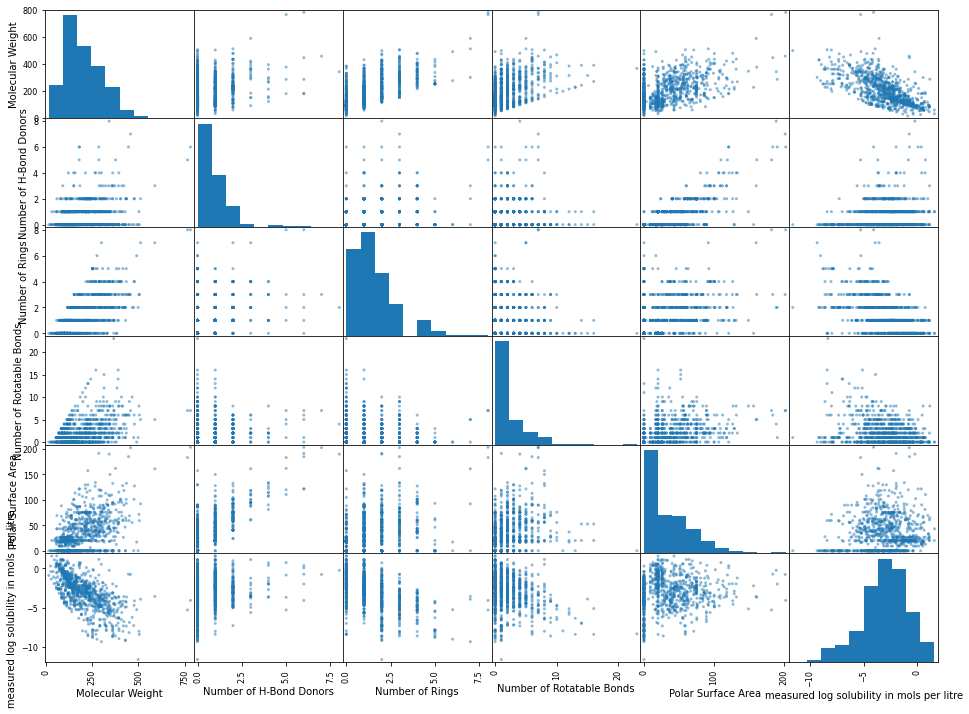

In [59]:
from pandas.plotting import scatter_matrix

scatter_matrix(train_copy, figsize=(16, 12))
plt.show()

```Molecular Weight``` and ```Number of Rings``` seem promising for predicting the measured log solubility.

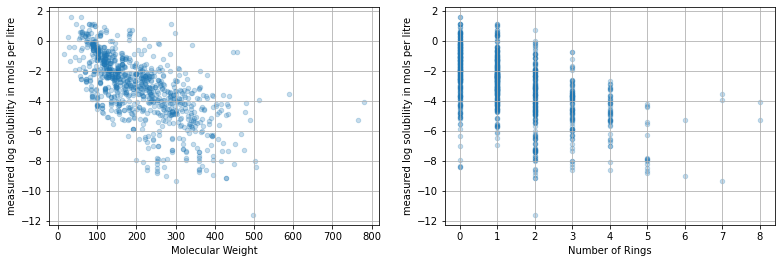

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
train_copy.plot(kind="scatter", x="Molecular Weight", y="measured log solubility in mols per litre", alpha=0.25, grid=True, ax=axs[0], )
train_copy.plot(kind="scatter", x="Number of Rings", y="measured log solubility in mols per litre", alpha=0.25, grid=True, ax=axs[1])
axs[0].set_xlabel("Molecular Weight")
axs[1].set_xlabel("Number of Rings")
axs[0].set_ylabel("measured log solubility in mols per litre")
plt.show()

Both plots show a negative correlation. The correlation is much clearer for the ```Molecular Weight```.

**Validation Set**

In [61]:
# create a copy
valid_copy = valid_set.copy()

In [62]:
# look for correlations
corr_matrix = valid_copy.corr()

corr_matrix['measured log solubility in mols per litre'].sort_values(ascending=False)

measured log solubility in mols per litre    1.000000
Number of H-Bond Donors                      0.287444
Polar Surface Area                           0.143770
Number of Rotatable Bonds                   -0.185840
Number of Rings                             -0.464991
Molecular Weight                            -0.540358
Name: measured log solubility in mols per litre, dtype: float64

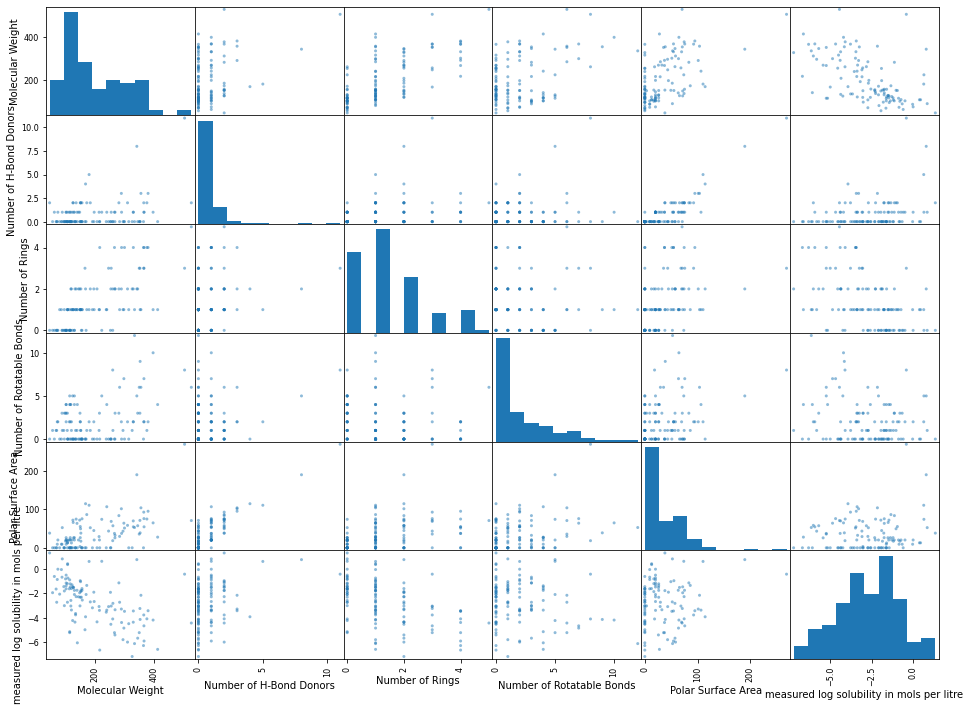

In [63]:
from pandas.plotting import scatter_matrix

scatter_matrix(valid_copy, figsize=(16, 12))
plt.show()

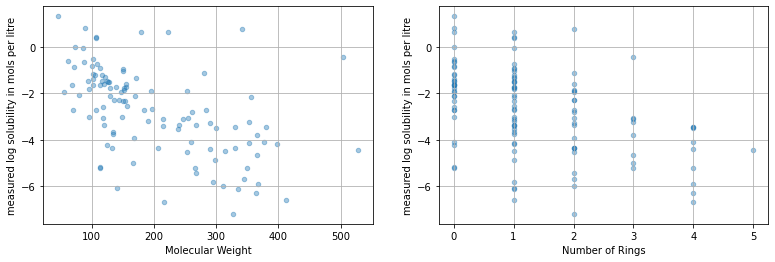

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
valid_copy.plot(kind="scatter", x="Molecular Weight", y="measured log solubility in mols per litre", alpha=0.4, grid=True, ax=axs[0], )
valid_copy.plot(kind="scatter", x="Number of Rings", y="measured log solubility in mols per litre", alpha=0.4, grid=True, ax=axs[1])
axs[0].set_xlabel("Molecular Weight")
axs[1].set_xlabel("Number of Rings")
axs[0].set_ylabel("measured log solubility in mols per litre")
plt.show()

Again, ```Molecular Weight``` and ```Number of Rings``` seem the most promising to predict the measured log solubility. The correlation is visually much weaker in the scatter plots of the validation set, however, the validation set also contains significantly less data.

Overall, the correlations between attributes in each set are similar. And the sets seem to be representative of each other.

### step 4: Prepare the Data

In [65]:
# separate the predictors and the labels
train_copy = train_set.drop('measured log solubility in mols per litre', axis=1)
train_set_labels = train_set['measured log solubility in mols per litre']

**transform and scale the features**

In [66]:
# skew of untransformed data
print(train_copy["Molecular Weight"].skew())
print(train_copy["Number of H-Bond Donors"].skew())
print(train_copy["Number of Rings"].skew())
print(train_copy["Number of Rotatable Bonds"].skew())
print(train_copy["Polar Surface Area"].skew())
print(train_set_labels.skew())

0.9352358632469852
2.4184151013256883
1.202098251109606
2.1974924919693435
1.2993490508797223
-0.5314393526782014


Many of the features are heavily skewed, with the exception of the labels

In [67]:
# skew of transformed data
print(train_copy["Number of H-Bond Donors"].apply(np.cbrt).skew())
print(train_copy["Number of Rings"].apply(np.cbrt).skew())
print(train_copy["Number of Rotatable Bonds"].apply(np.cbrt).skew())
print(train_copy["Polar Surface Area"].apply(np.cbrt).skew())
print(train_set_labels.skew())

0.4186934072461971
-0.5901218095293206
-0.23749975381152263
-0.5127695903271879
-0.5314393526782014


After transforming, the distribution of the data is much better

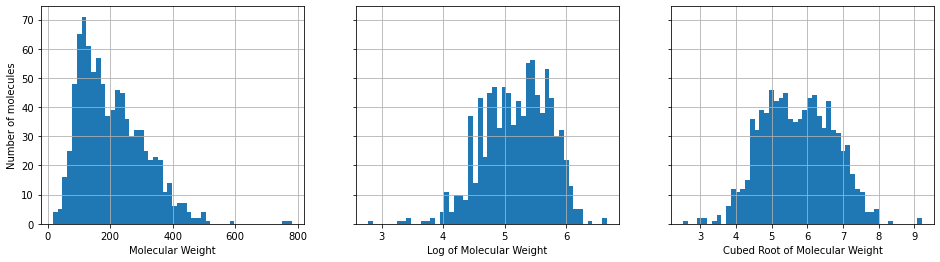

skew of Molecular Weight: 0.94
skew of log of MW: -0.42
skew of cbrt of MW: 0.06


In [68]:
# transform features that are skewed or have a heavy tail
from sklearn.preprocessing import FunctionTransformer

cbrt_transformer = FunctionTransformer(np.cbrt)
cbrt_MW = cbrt_transformer.transform(train_copy["Molecular Weight"])

log_transformer = FunctionTransformer(np.log)
log_MW = log_transformer.transform(train_copy["Molecular Weight"])

# extra code – show the effects of the transformations on the distribution
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
train_copy["Molecular Weight"].hist(ax=axs[0], bins=50)
train_copy["Molecular Weight"].apply(np.log).hist(ax=axs[1], bins=50)
train_copy["Molecular Weight"].apply(np.cbrt).hist(ax=axs[2], bins=50)
axs[0].set_xlabel("Molecular Weight")
axs[1].set_xlabel("Log of Molecular Weight")
axs[2].set_xlabel("Cubed Root of Molecular Weight")
axs[0].set_ylabel("Number of molecules")
plt.show()

# calculate the skewness of the distributions
print("skew of Molecular Weight:", train_copy["Molecular Weight"].skew().round(2))
print("skew of log of MW:", log_MW.skew().round(2))
print("skew of cbrt of MW:", cbrt_MW.skew().round(2))

Visual representation and mathematical representation that taking the cubed root of the ```Molecular Weight``` feature makes the feature the most symmetrical.

In [69]:
# min-max scale the input features
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_copy_min_max_scaled = min_max_scaler.fit_transform(train_copy)

In [70]:
# standardize the input features
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
train_copy_std_scaled = std_scaler.fit_transform(train_copy)

In [71]:
# transformation pipeline
from sklearn.pipeline import make_pipeline

feature_pipe = make_pipeline(FunctionTransformer(np.cbrt), StandardScaler())

### step 5. Select and Train ML Models

**Linear Regression Model**

In [72]:
from sklearn.linear_model import LinearRegression

# train model and look at predictions
line_model = make_pipeline(feature_pipe, LinearRegression())
line_model.fit(train_copy, train_set_labels)

line_predictions = line_model.predict(train_copy)

print(line_predictions[:5].round(3), ": prediction")
print(train_set_labels.iloc[:5].values, ": label")

# calculate percent error for each prediction — just for fun
error_per_prediction = np.divide(np.subtract(line_predictions, train_set_labels), train_set_labels)*100
print(error_per_prediction.iloc[:5].values.round(2), ": percent error")

[-4.639 -2.143 -5.207 -6.743 -4.933] : prediction
[-5.071 -3.22  -4.432 -7.39  -4.345] : label
[ -8.52 -33.44  17.48  -8.75  13.53] : percent error


At first glance this model works, but some of the predictions are a bit off. If we quickly perform some rudimentrary percent error calculations, we can see that the third prediction is off by about 47% and the fifth prediction is off by about -90%.

In [73]:
# correlation coefficient
np.corrcoef(line_predictions, train_set_labels)[1][0]

0.8641895514624968

The correlation coefficient between measured log solubility and the log solubility predicted by the linear regression model is approximately 0.859. If our predictions are perfect, we should expect a perfect correlation. Our value indicates a strong positive correlation which is what we would expect for accurate predictions.  It should be noted, however, that this is not as high as the correlation correficient for the ESOL model.

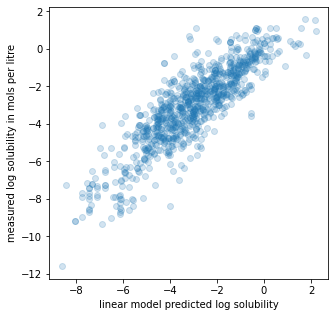

In [74]:
plt.figure(figsize=(5,5))
plt.scatter(line_predictions, train_set_labels, alpha=0.2)
plt.xlabel('linear model predicted log solubility')
plt.ylabel('measured log solubility in mols per litre')
plt.show()

When we plot the data, we can visualize the correlation. It is strong, but it is not as clear compared to the ESOL predictions.

In [75]:
# root mean square error
from sklearn.metrics import mean_squared_error

line_rmse = mean_squared_error(train_set_labels, 
                               line_predictions, 
                               squared=False)
line_rmse

1.0717662418659748

The linear regression model has a RMSE = 1.06, meaning we have a typical prediction error of 1.06 mols per Litre. Considering the range of the labels generally fall between -11.6 and 1.6, the  performance of this model is not too bad. It is not immediately clear is there is any overfitting or underfitting from the RMSE. 

In [76]:
# cross validation using SKL's k-fold cross validation feature
from sklearn.model_selection import cross_val_score

line_rmses = -cross_val_score(line_model, train_copy, train_set_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(line_rmses).describe()

count    10.000000
mean      1.073887
std       0.120736
min       0.878282
25%       0.976813
50%       1.119590
75%       1.158817
max       1.216793
dtype: float64

Evaluating with cross-validation, the linear regression model shows an average RMSE of 1.06 with a standard deviation of 0.126. This average RMSE is very close to the one we calculated and the standard deviation indicates a high precision for our calculated error.

In [77]:
# cross validation using the validation set
valid_copy = valid_set.drop('measured log solubility in mols per litre', axis=1)
valid_set_labels = valid_set['measured log solubility in mols per litre']

line_predictions_valid_set = line_model.predict(valid_copy)

print(line_predictions_valid_set[:5].round(2), ": first 5 predictions")
print(valid_set_labels.iloc[:5].values, ": first 5 labels\n")

# correlation coefficient
line_corr_valid_set = np.corrcoef(line_predictions_valid_set, valid_set_labels)[1][0]
print("correlation coefficent:", line_corr_valid_set)

line_rmse_valid_set = mean_squared_error(valid_set_labels, line_predictions_valid_set, squared=False)
print("RMSE:", line_rmse_valid_set)

[-3.84 -2.49 -2.99 -2.89 -2.36] : first 5 predictions
[-2.154 -3.38  -1.8   -3.01  -1.85 ] : first 5 labels

correlation coefficent: 0.7901983206380797
RMSE: 1.1890969328127874


The model does pretty well predicting the log solubility of the validation set. However, it seems to have the same problem that the accuracy of the predictions are not very consistent. The correlation coefficient and RMSE of the predictions on the validation set are quite similar to the predictions on the training set. Overall, the linear regression model seems to perform quite well, without any obvious issues of overfitting or underfitting.

**Decision Tree Regressor Model**

In [78]:
from sklearn.tree import DecisionTreeRegressor

tree_model = make_pipeline(feature_pipe, DecisionTreeRegressor())
tree_model.fit(train_copy, train_set_labels)

tree_predictions = tree_model.predict(train_copy)

print(tree_predictions[:5].round(2))
print(train_set_labels.iloc[:5].values)

[-5.07 -3.22 -4.43 -6.99 -4.34]
[-5.071 -3.22  -4.432 -7.39  -4.345]


Even before any calculations, we should be suspicious of overfitting. For the first five predictions, all match exactly down to the hundredths place, except for the third prediction which also only deviates slighty.

In [79]:
# correlation coefficient
np.corrcoef(train_set_labels, tree_predictions)[1][0]

0.9977084125174892

The correlation coefficient is significantly better than for the previous model. We should expect a strong correlation (close to 1) for good predictions, as that would be an indication of one-to-one mapping. Correlations very close to 1.00 should indicate perfect predictions, however, they can also be an indication of overfitting. Further evaluation is needed.

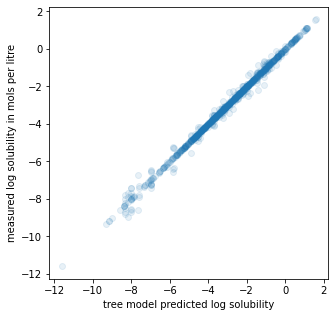

0.9977084125174893

In [80]:
plt.figure(figsize=(5,5))
plt.scatter(tree_predictions, train_set_labels, alpha=0.1)
plt.xlabel('tree model predicted log solubility')
plt.ylabel('measured log solubility in mols per litre')
plt.show()
np.corrcoef(tree_predictions, train_set_labels)[1][0]

The correlation for the decision tree model is much clearer than the linear model and even the ESOL model.

In [81]:
# root mean square error
tree_rmse = mean_squared_error(train_set_labels, 
                               tree_predictions, 
                               squared=False)
tree_rmse

0.14411949014281306

The decision tree model has a RMSE = 0.145, meaning we have a typical prediction error of 0.145 mols per Litre. This RMSE seems to indicate that the decision tree performs significally better than than linear regression model, however, we must check for overfitting.

In [82]:
# cross validation using SKL's k-fold cross validation feature
tree_rmses = -cross_val_score(tree_model, train_copy, train_set_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(tree_rmses).describe()

count    10.000000
mean      1.101615
std       0.173058
min       0.720072
25%       1.068082
50%       1.148083
75%       1.187960
max       1.331511
dtype: float64

Cross-validation indicates an average RMSE = 1.08 with a standard deviation of 0.188. This is significantly higher than the previously calculated RMSE = 0.145. These results indicate that the decision tree model performs roughly the same as the linear regression model, but is also has issues with overfitting.

In [83]:
# evaluation using cross-validation against the validation set
tree_predictions_valid_set = tree_model.predict(valid_copy)

print(tree_predictions_valid_set[:5].round(2), ": first 5 predictions")
print(valid_set_labels.iloc[:5].values, ": first 5 labels\n")

# correlation coefficient
tree_corr_valid_set = np.corrcoef(tree_predictions_valid_set, valid_set_labels)[1][0]
print("correlation coefficent:", tree_corr_valid_set)

tree_rmse_valid_set = mean_squared_error(valid_set_labels, tree_predictions_valid_set, squared=False)
print("RMSE:", tree_rmse_valid_set)

[-1.98 -0.85 -3.22 -3.82 -1.96] : first 5 predictions
[-2.154 -3.38  -1.8   -3.01  -1.85 ] : first 5 labels

correlation coefficent: 0.8523908788765465
RMSE: 1.073295315319335


Evaluation using the validation set yields a higher RMSE than the RMSE training set predictions and than the RMSE of the SKL cross-validation feature. This provides further evidence that the decision tree model was overfitted to the training set. We also note that the correlation for the tree model's predictions on the validation set has decreased as well. Overall, this model suffers from many issues of overfitting. Of the two models so far, the linear regression model seems to perform better and with less issues than the decision tree model.

**Random Forest Regressor Model**

In [84]:
from sklearn.ensemble import RandomForestRegressor

forest_model = make_pipeline(feature_pipe, RandomForestRegressor())
forest_model.fit(train_copy, train_set_labels)

forest_predictions = forest_model.predict(train_copy)

print(forest_predictions[:5].round(2), ": random forest predicted log solubility")
print(train_set_labels.iloc[:5].values, ": measured log solubility in mols per litre")

# calculate percent error for each prediction
error_per_prediction = np.divide(np.subtract(forest_predictions, train_set_labels), train_set_labels)*100
print(error_per_prediction.iloc[:5].values.round(2), ": percent error")

[-5.09 -2.96 -4.76 -6.99 -4.32] : random forest predicted log solubility
[-5.071 -3.22  -4.432 -7.39  -4.345] : measured log solubility in mols per litre
[ 0.45 -7.93  7.34 -5.47 -0.61] : percent error


Glancing at the first five predictions, this model seems to be doing relatively well. The percent difference between the predicted log solubility and the measured log solubility seems to be lower than that of the linear model.

In [85]:
# correlation coefficient
np.corrcoef(train_set_labels, forest_predictions)[1][0]

0.9878279594991062

Again, the correlation is very strong, and almost so strong that it is suspicious. It is higher than the correlations that were calculated for the linear regression and and ESOL models.

In [86]:
# root mean square error
forest_rmse = mean_squared_error(train_set_labels, 
                               forest_predictions, 
                               squared=False)
forest_rmse

0.3396235387378594

RMSE = 0.347 means a typical prediction error of 0.347 mols per litre. This seems to indicate that the random forest model performs significantly better than the linear regression and decision tree models. That being said, we should still evaluate the model using cross-validation.

In [87]:
# cross validation using SKL
forest_rmses = -cross_val_score(forest_model, train_copy, train_set_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(forest_rmses).describe()

count    10.000000
mean      0.852419
std       0.118108
min       0.661806
25%       0.799671
50%       0.870736
75%       0.935211
max       1.007054
dtype: float64

Cross-validation indicates a mean RMSE of 0.87 with a standard deviation of 0.14. This indicates that the model has slight issues with overfitting.

In [88]:
# evaluation using cross-validation against the validation set
forest_predictions_valid_set = forest_model.predict(valid_copy)

print(forest_predictions_valid_set[:5].round(2), ": first 5 predictions")
print(valid_set_labels.iloc[:5].values, ": first 5 labels\n")

# correlation coefficient
forest_corr_valid_set = np.corrcoef(forest_predictions_valid_set, valid_set_labels)[1][0]
print("correlation coefficent:", forest_corr_valid_set)

forest_rmse_valid_set = mean_squared_error(valid_set_labels, forest_predictions_valid_set, squared=False)
print("RMSE:", forest_rmse_valid_set)

[-3.44 -2.32 -3.18 -3.57 -2.03] : first 5 predictions
[-2.154 -3.38  -1.8   -3.01  -1.85 ] : first 5 labels

correlation coefficent: 0.8819584959569806
RMSE: 0.9115151949757947


Evaluation against the validation set supports the results of SKL cross-validation, showing that there is some overfitting to the training data. Correlation of predictions and labels using the validation data has decreased slightly, showing further evidence of overfitting. The performance of the model across the difference evaluations is the best for this random forest model. Even with overfitting being taken into account, **the random forest model performs better than the linear regression and decision tree models.**

### step 6: Fine-Tune the Model

In [89]:
# fine-tune using GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", feature_pipe),
    ("random_forest", RandomForestRegressor())
])

param_grid = [{'random_forest__max_features': [2, 3, 4, 5, 6]}]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                          scoring='neg_root_mean_squared_error')
grid_search.fit(train_copy, train_set_labels)
grid_search.best_params_

{'random_forest__max_features': 2}

In [90]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.181550,0.013630,0.015047,0.000314,2,{'random_forest__max_features': 2},-0.913910,-0.814461,-0.908499,-0.878956,0.045659,1
1,0.214357,0.014415,0.016754,0.000963,3,{'random_forest__max_features': 3},-0.939397,-0.810103,-0.887715,-0.879072,0.053137,2
2,0.238689,0.002442,0.017980,0.000107,4,{'random_forest__max_features': 4},-0.923722,-0.823773,-0.908660,-0.885385,0.043998,3
3,0.242752,0.009758,0.016005,0.000901,5,{'random_forest__max_features': 5},-0.955898,-0.822061,-0.884601,-0.887520,0.054678,4
4,0.248707,0.019494,0.016661,0.001364,6,{'random_forest__max_features': 6},-0.940572,-0.832866,-0.894092,-0.889177,0.044108,5


The best results for hyperparameter tuning seems to come from setting ```max_features``` to 3, however, it is not clear if it is significantly better than the default.

In [91]:
# probe the relative importances of each attribute
final_model = grid_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_

sorted(zip(feature_importances,
           feature_pipe[1].get_feature_names_out()), 
           reverse=True)

[(0.4485775228425968, 'Molecular Weight'),
 (0.20744734993489508, 'Polar Surface Area'),
 (0.19650575090151395, 'Number of Rings'),
 (0.0949833415172114, 'Number of Rotatable Bonds'),
 (0.05248603480378293, 'Number of H-Bond Donors')]

```Molecular Weight``` seems to be the most useful category, while ```Number of Rotatable Bonds``` and ```Number of H-bond Donors``` seem to be the least useful. That being said, I will not drop any categories yet. This may be useful information for future tweaking of the model.

**Evaluate on the Test Set**

In [92]:
X_test = test_set.drop("measured log solubility in mols per litre", axis=1)
y_test = test_set["measured log solubility in mols per litre"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print("RMSE:", final_rmse)

final_corr = np.corrcoef(final_predictions, y_test)[1][0]
print("corr:", final_corr)

RMSE: 0.8219229507951105
corr: 0.9140408457612877


This final RMSE is lower than the RMSE of the ESOL predicted log solubility. In addition, the correlation coefficient of this model seems to indicate better one-to-one mapping with the labels.

In [93]:
# compute 95% confidence interval
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.66985481, 0.94995222])

The upper-bound of the range provided by the 95% confidence interval is also lower than the RMSE of the ESOL predcicted log solubility. This seems to indicate that our model performs better than the ESOL model.

### step 7: Conclusions

Of the three models that were trained, the random forest regression model performed the best across it's predictions for the training and validation sets. The RMSE was low relative to the range of the labels with high precision as seen from the confidence interval. That being said, it should be noted that what we predicted with our model was the *log of solubility* and not the solubility itself. When predictions are transformed into useful solubility values, any error will increase exponentially. 

Based on the RMSE, it seems that the random forest model performs better than ESOL model. The random forest model has a lower RMSE which is used as the measure of performance in this ML project. In addition, there is a stronger positive linear correlation between the labels and the predictions of the final forest model than between the labels and the ESOL predictions. A stronger correlation and a scatter plot which represents $y=x$ is is what it would look like if we plotted the labels against themselves. Since my model has a stronger correlation and lower RMSE than the ESOL predicted values, I would conclude that for the provided data, my model performs better.

That being said, there are some further aspects of this random forest model which I believe could be further built upon. Not all of the data shows strong correlation with log solubility. In addition, much of the data is discrete and heavily skewed right. I took the cubed root off all the data to tweak their distributions, but there might be combinations of data and additional transformations which could improve the model further if we investigate. 

### step 8: Launch, Monitor, and Maintain the Model

No, not yet.